# Train

In [14]:
%run keras_retinanet/bin/train.py --batch-size 1 --epochs 1 --steps 50 coco dataset/coco

Creating generators, this may take a second...
loading annotations into memory...
Done (t=15.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Creating model, this may take a second...


/Users/luke/Documents/dev/github/fingerplus/edwin-jarvis/keras-retinanet/keras_retinanet/bin/train.py:89: UserWarning: Output "concatenate_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "concatenate_12" during training.
  optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)


Creating callback
training
Epoch 1/1
50/50 [==============================] - 639s 13s/step - loss: 4.5166 - regression_loss: 1.1657 - classification_loss: 3.3508


OSError: Unable to create file (unable to open file: name = './snapshots', errno = 21, error message = 'Is a directory', flags = 13, o_flags = 602)

# Predict

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

/Users/luke/.pyenv/versions/3.6.2/envs/py362/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
mymodel = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_epoch_01_loss_2.19358.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.2/envs/py362/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "non_maximum_suppression_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_1" during training.
  sample_weight_mode=sample_weight_mode)
/Users/luke/.pyenv/versions/3.6.2/envs/py362/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [4]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    '../dataset/all',
    'val2017',
    transform_generator=val_image_data_generator,
    batch_size=1,
)
index = 0

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
skip - generator.py - order.sort(key=lambda x: self.image_aspect_ratio(x))


(427, 640, 3)
(600, 899, 3) 1.405152224824356
processing time:  6.94338321685791
processing time:  7.007784843444824


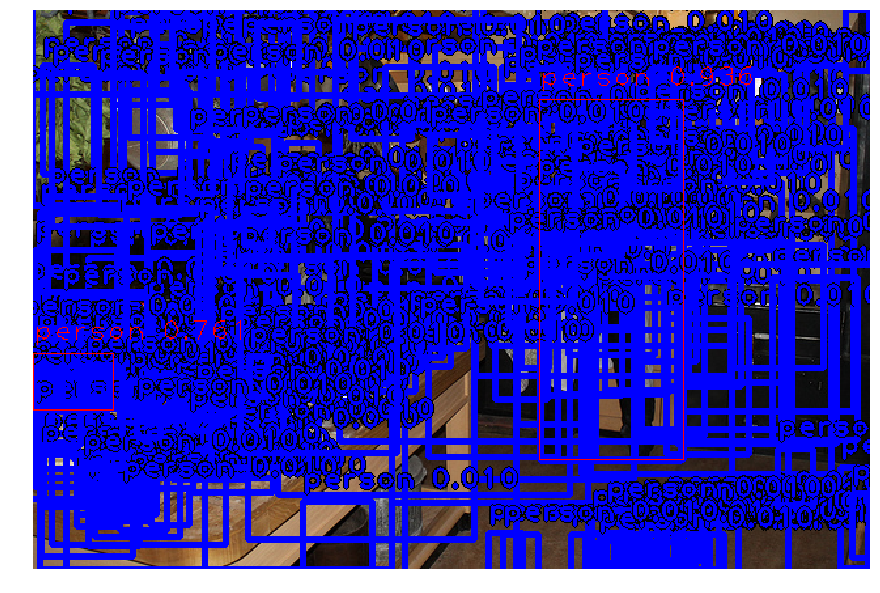

In [6]:
# load image
image = val_generator.load_image(index)
print(image.shape)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)

print(image.shape, scale)
annotations = val_generator.load_annotations(index)
# index += 1

# process image
start = time.time()
_, _, detections = mymodel.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    
# visualize annotations
# for annotation in annotations:
#     label = int(annotation[4])
#     b = annotation[:4].astype(int)
#     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     caption = "{}".format(val_generator.label_to_name(label))
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
    
# plt.figure(figsize=(15, 15))
# plt.axis('off')
# plt.imshow(draw)
# plt.show()






# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.7:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 1)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 0, 0), 1)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [7]:
for i in range(0, 120): 
    print(val_generator.label_to_name(i))
    

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush
Anorak
Blazer
Blouse
Bomber
Button-Down
Cardigan
Flannel
Halter
Henley
Hoodie
Jacket
Jersey
Parka
Peacoat
Poncho
Sweater
Tank
Tee
Top
Turtleneck
Capris
Chinos
Culottes
Cutoffs
Gauchos
Jeans
Jeggings
Jodhpurs
Joggers
Leggings
Sarong
Shorts
Skirt
Sweatpants
Sweatshorts
Trunks
Caftan
Cape
Coat
Coverup
